### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
# < A whole lot of your code > - models, charts, analysis
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import gensim
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
102054,69550937,Hotel Head Chef,"Thistle Glasgow has 300 bedrooms, an Otium Hea...",Glasgow,Glasgow,full_time,NaN,Thistle and Guoman Hotels,Hospitality & Catering Jobs,"34,000.00 - 35,000.00 per year",34500,Jobcentre Plus,10.448744
168438,71328588,Cleaner ****,Cleaning operative required. Experience prefer...,Smethwick,Smethwick,part_time,NaN,Ratcliffe Cleaning Contractors,Maintenance Jobs,6.25 - 6.25 per hour,12000,Jobcentre Plus,9.392745
41866,68409287,Driver (**** tonne / Class C****),To apply please email CV to hewiwrist.com Stra...,Peterhead,Peterhead,full_time,NaN,Strachan Ltd,Logistics & Warehouse Jobs,6.69 - 6.69 per hour,12844,Jobcentre Plus,9.460710


In [3]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()
data['Title'] = data["Title"].apply(lambda x: " ".join(tokenizer.tokenize(str(x))).lower())
data['FullDescription'] = data["FullDescription"].apply(lambda x: " ".join(tokenizer.tokenize(str(x))).lower())
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,engineering systems analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,stress engineer glasgow,stress engineer glasgow salary **** to **** we...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,modelling and simulation analyst,mathematical modeller / simulation analyst / o...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986
3,12613049,engineering systems analyst / mathematical mod...,engineering systems analyst / mathematical mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk,10.221977
4,12613647,"pioneer , miser engineering systems analyst","pioneer , miser engineering systems analyst do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671


In [4]:
import json
with open("token_counts.json" , "r") as f:
    token_counts = json.load(f)

min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens



### Create pretrained embedding matrix for our vocabulary

In [5]:
from gensim import downloader
wv = downloader.load('fasttext-wiki-news-subwords-300')
EMBEDDING_DIM = 300

In [38]:

embeddings = torch.randn([2,EMBEDDING_DIM]) # init matrix with [UNK, PAD] randn vectors

for i in range(len(tokens)-1,1,-1):
    try:
        embeddings = torch.cat((embeddings,torch.Tensor(wv.get_vector(tokens[i])).unsqueeze(0)))
    except KeyError:
        tokens.pop(i) ## exclude tokens which don't have pretrained embedding

embeddings_mask = torch.ones_like(embeddings).cuda()
embeddings_mask[:2] *=0

In [25]:
token_to_id = dict((tokens[i],i) for i in range(len(tokens)))
print(len(tokens))

24213


In [8]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [9]:
from sklearn.feature_extraction import DictVectorizer
from collections import Counter

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [10]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

UNK_IX = 0
PAD_IX = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [12]:
class AttentivePooling(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentivePooling, self).__init__()
        self.weights = nn.Linear(input_dim, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1, bias=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(1)

    def forward(self, inpup):
        x = self.weights(inpup)
        x = self.tanh(x) #(-1,1)
        x = self.context(x).squeeze(-1) # squeeze input to (N,L) using fc layer
        x = self.softmax(x)
        
        out = torch.bmm(x.unsqueeze(1), inpup).squeeze(1) # (N,1,L)@(N,L,H) -> (N,H)
        return out




class ConvBlock(nn.Module):
    def __init__(self,input_size,hid_size,n_layers,kernel_size):
        super().__init__()
        layers = nn.ModuleList()
        for i in range(n_layers):
            if i == 0:
                layers.append(nn.Conv1d(input_size,hid_size,kernel_size=kernel_size,padding=kernel_size//2))
            else:
                layers.append(nn.Conv1d(hid_size,hid_size,kernel_size=kernel_size,padding=kernel_size//2))
        
            layers.append(nn.BatchNorm1d(hid_size))
            layers.append(nn.LeakyReLU())
        layers.append(nn.Conv1d(hid_size,hid_size,kernel_size=kernel_size,padding=kernel_size//2))
        self.seq = nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.seq(x)
        return torch.sum(torch.nn.functional.softmax(x,dim=-1) * x,dim=-1) # stateless softmax pool


class ConvEncoder(nn.Module):
    def __init__(self,input_size,hid_size,n_layers,dropout = 0.4,kernels = (3,5)):
        super().__init__()
        self.kernels = kernels
        self.dropout = nn.Dropout(dropout)
        for k in kernels:
            self.__setattr__(f"layers{k}",ConvBlock(input_size,hid_size,n_layers,k))
    def forward(self,x):
        x = x.permute(0,2,1)
        out = None
        for k in self.kernels:
            if out is None:
                out = self.dropout(self.__getattr__(f"layers{k}")(x))
            else:
                out += self.dropout(self.__getattr__(f"layers{k}")(x))
        return out
    

class RNNEncoder(nn.Module):
    def __init__(self,input_size,hid_size,num_layers,dropout = 0.4):
        super().__init__()
        self.lstm = nn.LSTM(input_size,hid_size,num_layers,bidirectional = True,batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.pool = AttentivePooling(hid_size*2,hid_size)

    def forward(self,x):
        hidden, c_n = self.lstm(x)
        hidden = self.dropout(hidden)

        return self.pool(hidden)
    

class MLP(nn.Module):
    def __init__(self,input_size,hid_size,output_size,n_layers,dropout = 0.4):
        super().__init__()
        layers = nn.ModuleList()
        self.beta = nn.Parameter(torch.Tensor([0.5]))
        for i in range(n_layers):
            if i == 0:
                self.res = nn.Linear(input_size,hid_size)
            else:
                layers.append(nn.Linear(hid_size,hid_size))
            layers.append(nn.BatchNorm1d(hid_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        self.out = nn.Linear(hid_size*2,output_size)
        self.seq = nn.Sequential(*layers)
    def forward(self,x):
        skip = self.res(x)
        x = self.seq(skip)
        return self.out(torch.cat((skip,x),dim=1))
    

class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens),embedding_dim = EMBEDDING_DIM, n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64,pretrained_embeddings = None):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens,embedding_dim,1)

        # Use the embedding matrix as weights for embedding layer
        if pretrained_embeddings != None:
            self.embedding.weight = torch.nn.Parameter(pretrained_embeddings)
        
        # Linear model for categorical features
        self.cat_input =MLP(n_cat_features,hid_size*2,hid_size,2,dropout = 0.4)

        # Conv model for title features
        self.title_cnn = ConvEncoder(embedding_dim,hid_size,2,kernels=(3,2),dropout = 0.4)

        # Reccurent model for descriptions
        self.description_rnn = RNNEncoder(embedding_dim,hid_size,1,dropout = 0.4)

        # FC classifier
        self.classifier = MLP(hid_size*4,hid_size,1,1)

        self.norm = nn.BatchNorm1d(hid_size*4)
        self.act = nn.ReLU()
        
    def forward(self, batch):
        # YOUR CODE HERE
        title_emb = self.embedding(batch['Title'])
        title_out = self.title_cnn(title_emb)

        desc_emb = self.embedding(batch['FullDescription'])
        desc_out = self.description_rnn(desc_emb)
        cat_out = self.cat_input(batch["Categorical"])


        out = torch.cat((title_out,desc_out,cat_out),dim=1)
        
        out = self.classifier(out).view(-1)
        return out

In [13]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

In [14]:
from tqdm import tqdm

BATCH_SIZE = 64
EPOCHS = 100
%matplotlib inline

In [15]:
from IPython.display import clear_output
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    # print("%s results:" % (name or ""))
    # print("Mean square error: %.5f" % mse)
    # print("Mean absolute error: %.5f" % mae)
    clear_output(True)
    total_mae.append(mae)
    total_mse.append(mse)
    plt.figure(figsize=(16,9))
    plt.grid(True)
    plt.plot(total_mse)
    plt.plot(total_mae)
    plt.plot(total_loss)
    plt.legend([f"MSE: {mse:.5f}",f"MAE: {mae:.5f}",f"MSE train: {total_loss[-1]:.5f}"])
    plt.show()
    return mse, mae

In [ ]:
model = SalaryPredictor(pretrained_embeddings=embeddings).to(device)

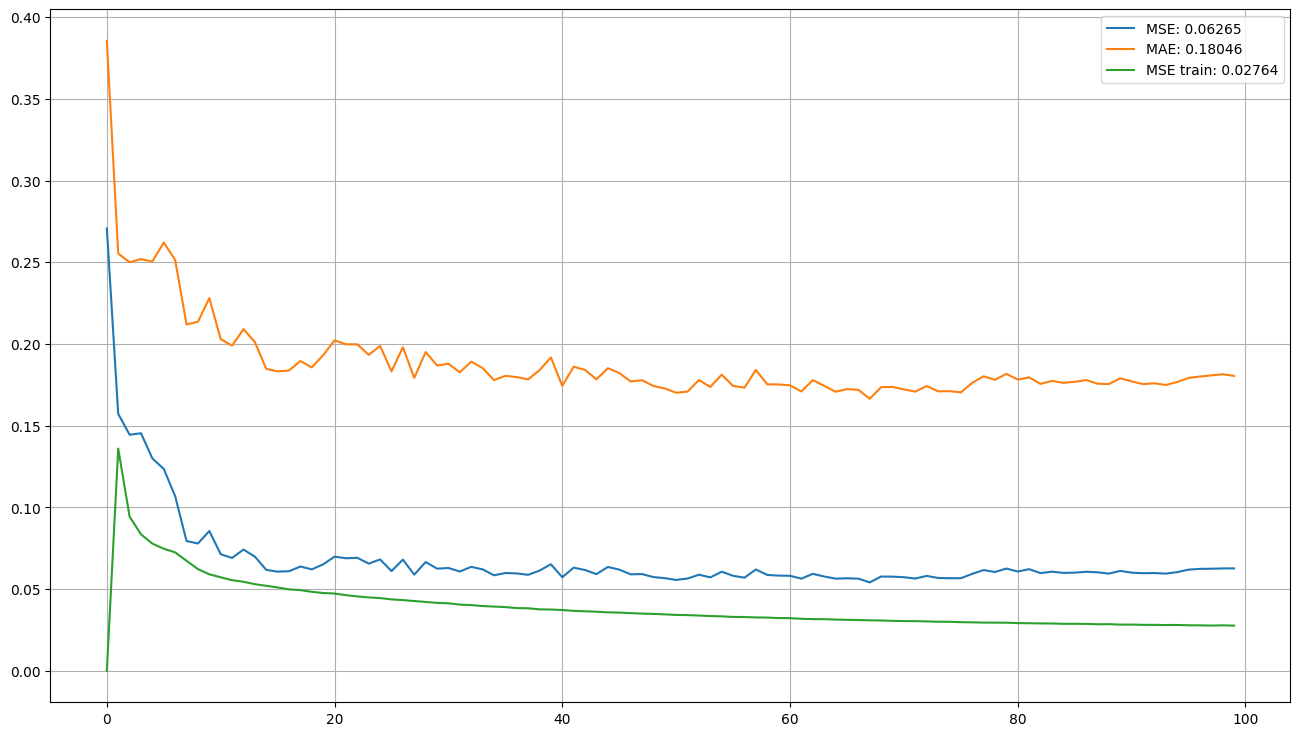

In [39]:

criterion = nn.MSELoss(reduction='mean')
lr = 1e-4
lr_decay_curve = 0.5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=1e-3)
total_mse = []
total_mae = []
total_loss = []
for epoch in range(EPOCHS):
    total_loss.append(0)
    print(f"epoch: {epoch}")
    model.train()
    optimizer.param_groups[0]['lr'] = lr-lr*((epoch/EPOCHS)**lr_decay_curve)
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device,word_dropout = 0.4)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        if epoch > 0:
            total_loss[-1]+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        #inverse learning rate decay dependancy regularization, i guess keeping embedding gradients low forces model to match general patterns between tokens independent from training data
        embds = model.state_dict(keep_vars=True)['embedding.weight'].grad
        embds *= (epoch/EPOCHS)**(lr_decay_curve*embeddings_mask)
        
        
        
        
    
            
        optimizer.step()
    total_loss[-1]/=(i+1)
        
    mse,mae = print_metrics(model, data_val, device=device)
    torch.save(model.state_dict(),f"{loss.item():.4f},{epoch}")

      

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess i am stupid


## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!